# Compute seasonal NVDI within distance from water

This notebook demonstrates how to load Landsat time series data, identify water pixels using the WOFS algorithm for seasonal periods, calculate distance from the edge of water, and return a time series of potential productive terrain within a distance limit of water.

**Author**: Robbi Bishop-Taylor

**Date**: 30 October 2018

In [6]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
from rasterio.features import shapes
from shapely import geometry
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
from skimage import measure
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.ama_utils.dc_display_map import display_map
from utils.data_cube_utilities.ama_utils.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.ama_utils.dc_utilities import ignore_warnings

dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')


## Set up analysis

In [7]:
platform = "LANDSAT_8"
product = "ls8_lasrc_tanzania"

In [14]:
# Area with water
latitude_extents = (-4.65, -4.88)
longitude_extents = (34.7, 34.9)
time_extents = ('2013-01-01', '2018-11-01')

In [183]:
display_map(latitude_extents, longitude_extents)

## Import data

In [ ]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'], 
                          time = time_extents,
                          group_by = 'solar_day')
landsat_dataset


### Mask out clouds

In [17]:
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)
cleaned_dataset

<xarray.Dataset>
Dimensions:    (latitude: 848, longitude: 738, time: 104)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-28T07:51:55 ... 2017-12-19T07:50:21
  * latitude   (latitude) float64 -4.65 -4.65 -4.651 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 34.9 34.9 34.9 34.9
Data variables:
    red        (time, latitude, longitude) float64 1.683e+03 1.689e+03 ... 970.0
    green      (time, latitude, longitude) float64 1.297e+03 1.347e+03 ... 882.0
    blue       (time, latitude, longitude) float64 692.0 799.0 ... 567.0 428.0
    nir        (time, latitude, longitude) float64 3.637e+03 ... 2.994e+03
    swir1      (time, latitude, longitude) float64 3.258e+03 ... 2.532e+03
    swir2      (time, latitude, longitude) float64 2.14e+03 ... 1.816e+03
    pixel_qa   (time, latitude, longitude) float64 322.0 322.0 ... 322.0 322.0
Attributes:
    crs:      EPSG:4326

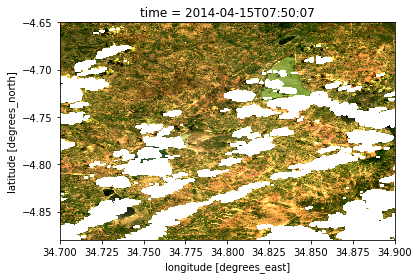

In [18]:
cleaned_dataset[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True)

## Classify water using Water Observations From Space (WOFS) algorithm

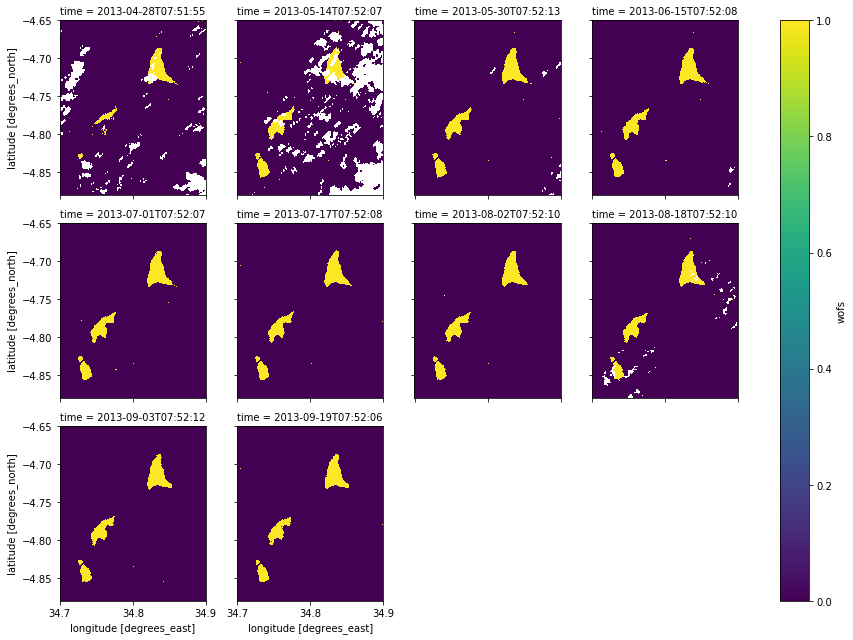

In [19]:
# Identify surface water, fix nodata and remove clouds
wofs_arr = ignore_warnings(wofs_classify, cleaned_dataset).wofs
wofs_arr = wofs_arr.where(wofs_arr != -9999, other=0)
wofs_arr = wofs_arr.where(cloud_mask)

# Add back into original dataset
cleaned_dataset['wofs'] = wofs_arr

# Plot example
cleaned_dataset['wofs'].isel(time=range(0, 10)).plot(col='time', col_wrap=4)


## Calculate NDVI vegetation index

In [20]:
cleaned_dataset['ndvi'] = ((cleaned_dataset.nir - cleaned_dataset.red) / (cleaned_dataset.nir + cleaned_dataset.red))

### Aggregate seasonally
Calculate median water extent per season period

In [82]:
seasonal_persistent = cleaned_dataset[['wofs', 'ndvi']].resample(time="QS-DEC").median(dim='time')
seasonal_persistent 

<xarray.Dataset>
Dimensions:    (latitude: 848, longitude: 738, time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2013-03-01 2013-06-01 ... 2017-12-01
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 34.9 34.9 34.9 34.9
  * latitude   (latitude) float64 -4.65 -4.65 -4.651 ... -4.879 -4.88 -4.88
Data variables:
    wofs       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ndvi       (time, latitude, longitude) float64 0.3616 0.2895 ... 0.4399

## Calculate distance from water for every pixel in study area

In [73]:
# Compute Euclidean distance to edge of water for all non-water pixels
from scipy import ndimage as nd
distance = [nd.distance_transform_edt(i != 1) for i in seasonal_persistent.wofs]
distance_arrays = np.stack(distance)

# Do an approximate conversion to metres (1 decimal second at equator = 30.87 m)
distance_arrays = distance_arrays * 30.87

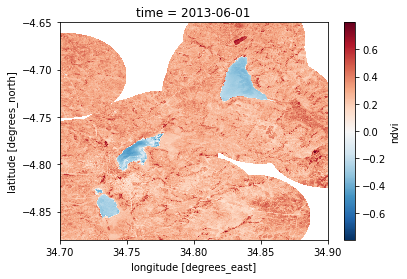

In [74]:
# Remove areas more distant than 5000 m from water
seasonal_nearwater = seasonal_persistent.where(distance_arrays < 5000)

# Plot example of array clipped to less than 5000km
seasonal_nearwater.isel(time=1).ndvi.plot()

### Plot average distance to water across time

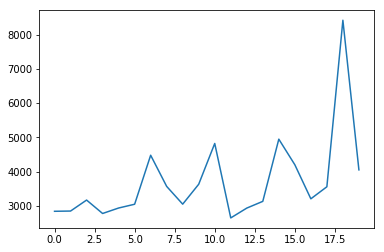

In [75]:
plt.plot(np.mean(distance_arrays, axis=(1,2)))

## Plot average NDVI across time

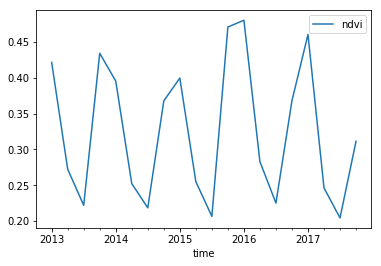

In [76]:
seasonal_ndvi_prop = (seasonal_nearwater.ndvi).mean(dim=['longitude', 'latitude']).to_dataframe()
seasonal_ndvi_prop.plot()

## Plot average NDVI by season

In [77]:
seasonal_ndvi_prop['season'] = seasonal_ndvi_prop.index.strftime('%B')
seasonal_ndvi_prop

,ndvi,season
time,,
2013-03-01,0.421426,March
2013-06-01,0.272318,June
2013-09-01,0.221890,September
2013-12-01,0.434210,December
2014-03-01,0.395313,March
2014-06-01,0.252189,June
2014-09-01,0.218334,September
2014-12-01,0.367729,December
2015-03-01,0.399606,March


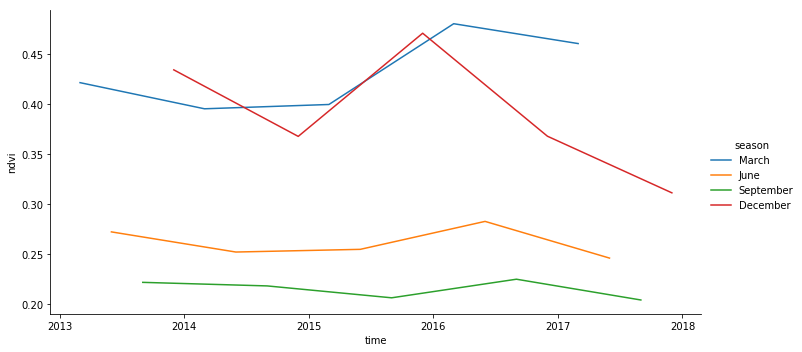

In [78]:
import seaborn as sns
fg = sns.FacetGrid(data=seasonal_ndvi_prop.reset_index(), hue='season', size=5, aspect=2)
fg.map(plt.plot, 'time', 'ndvi').add_legend()

## Plot NDVI histograms across time

<Figure size 432x288 with 0 Axes>

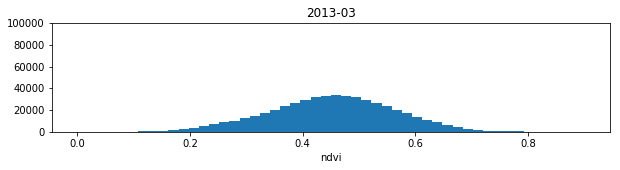

<Figure size 432x288 with 0 Axes>

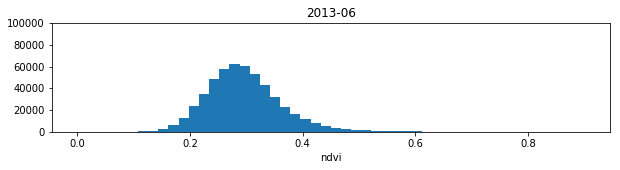

<Figure size 432x288 with 0 Axes>

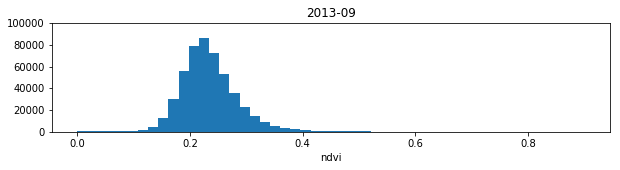

<Figure size 432x288 with 0 Axes>

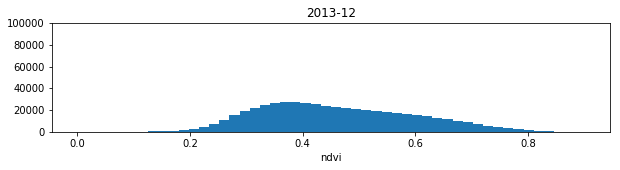

<Figure size 432x288 with 0 Axes>

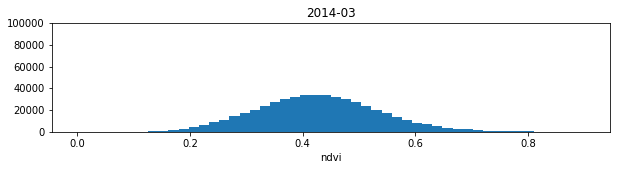

<Figure size 432x288 with 0 Axes>

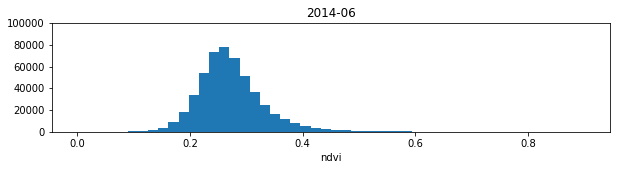

<Figure size 432x288 with 0 Axes>

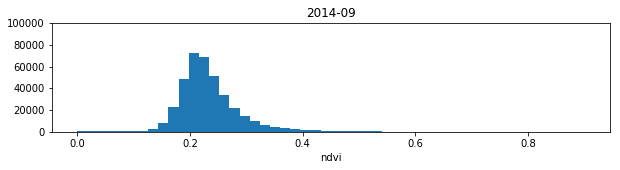

<Figure size 432x288 with 0 Axes>

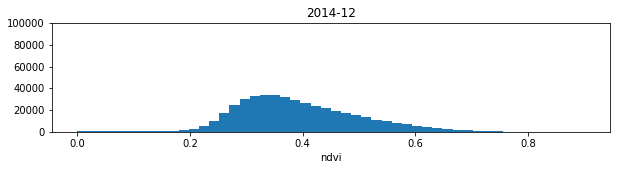

<Figure size 432x288 with 0 Axes>

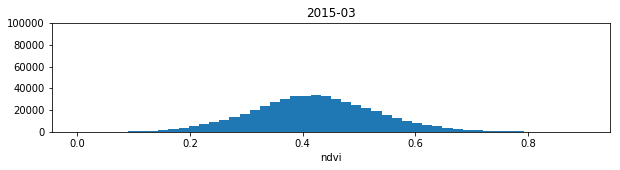

<Figure size 432x288 with 0 Axes>

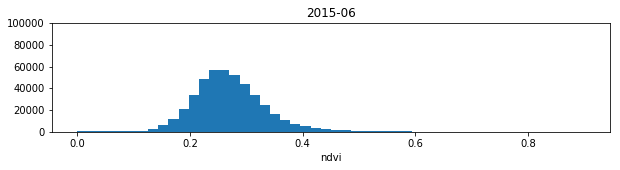

<Figure size 432x288 with 0 Axes>

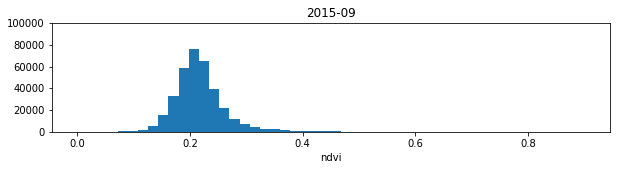

<Figure size 432x288 with 0 Axes>

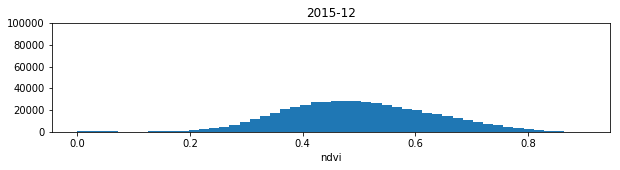

<Figure size 432x288 with 0 Axes>

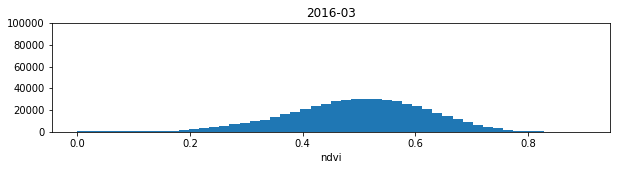

<Figure size 432x288 with 0 Axes>

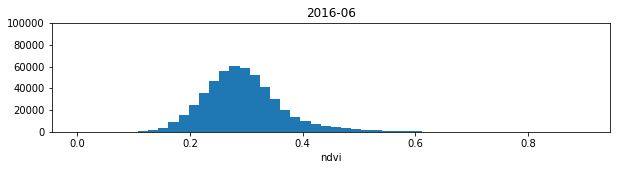

<Figure size 432x288 with 0 Axes>

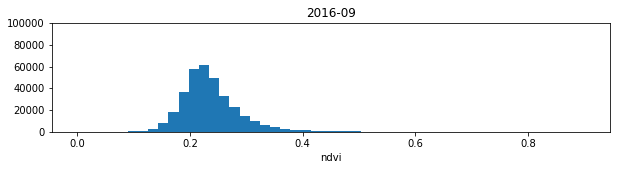

<Figure size 432x288 with 0 Axes>

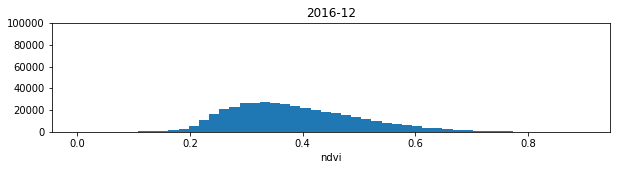

<Figure size 432x288 with 0 Axes>

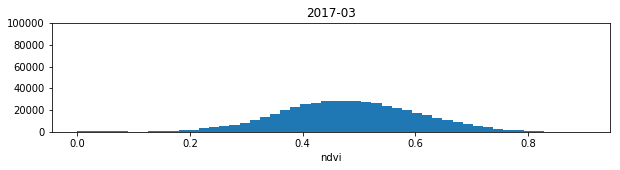

<Figure size 432x288 with 0 Axes>

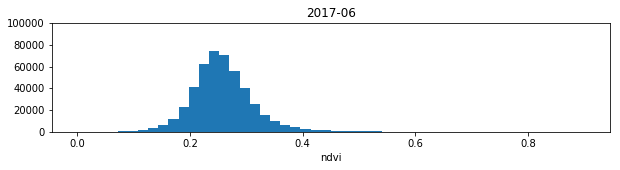

<Figure size 432x288 with 0 Axes>

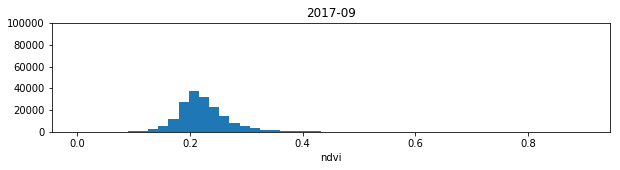

<Figure size 432x288 with 0 Axes>

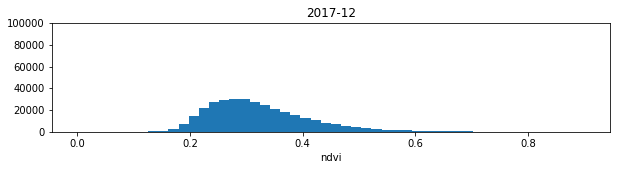

In [79]:
for i in range(0, 20):
    plt.figure()
    seasonal_nearwater.isel(time=i).ndvi.plot.hist(bins=50, range = (0, 0.9), figsize=(10, 2), ylim=(0,100000))
    plt.title(str(seasonal_nearwater.time.isel(time=i).values)[:7])

## Compare bare soil and growing vegetation within proximity to water

In [180]:
# Create seasonal Landsat composites (this uses a simple median for processing speed, but should be replaced with a
# geomedian composite method which preserves relationships between spectral bands)
seasonal_landsat = cleaned_dataset[['red', 'green', 'blue', 'nir', 'swir1', 'swir2']].resample(time="QS-DEC").median(dim='time')

# Remove pixels located further than X metres from water, and wet pixels where Fractional Cover performs poorly
seasonal_landsat = seasonal_landsat.where(distance_arrays < 5000).where(seasonal_persistent.wofs == 0)

# The fractional cover algorithm is slow on large datasets. For the sake of processing speed, downsample data to 3x 
# the spatial resolution. This can be removed.
seasonal_landsat = seasonal_landsat.interp(longitude=seasonal_landsat.longitude[0::3], 
                                           latitude=seasonal_landsat.latitude[0::3], method='nearest')

### Plot histograms of bare soil and growing vegetation across time

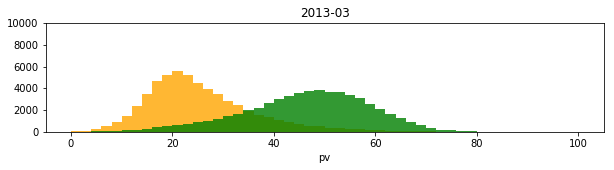

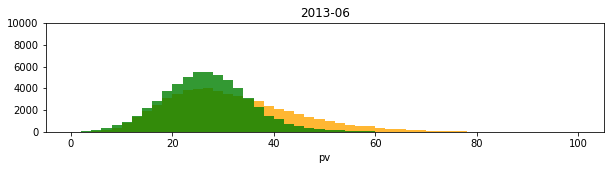

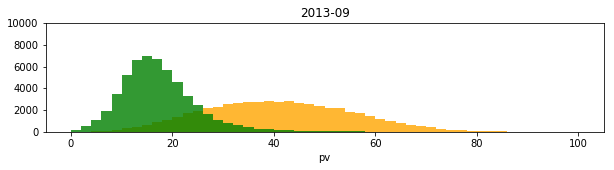

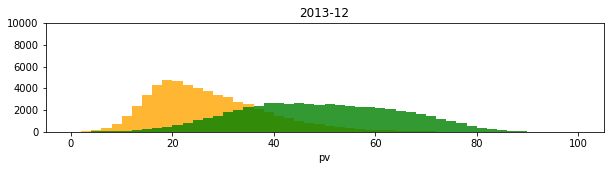

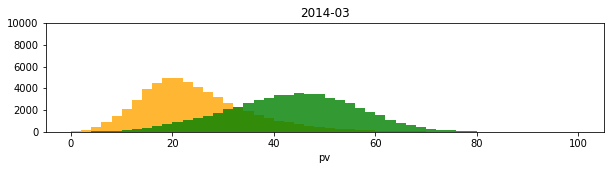

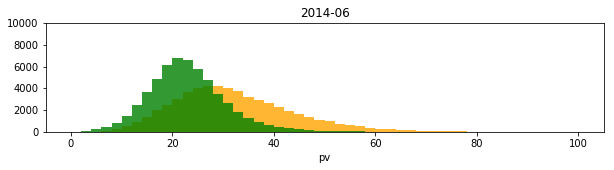

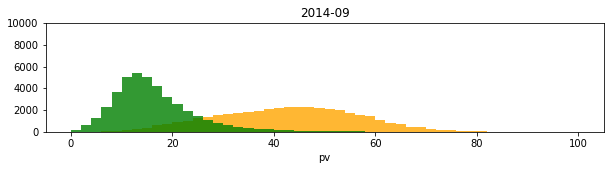

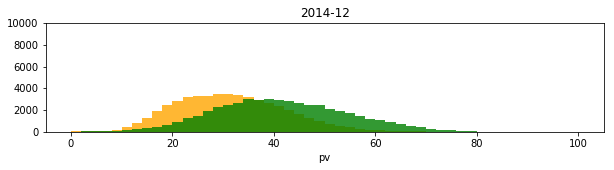

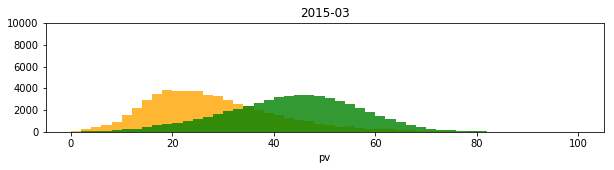

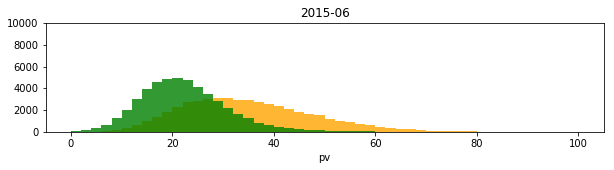

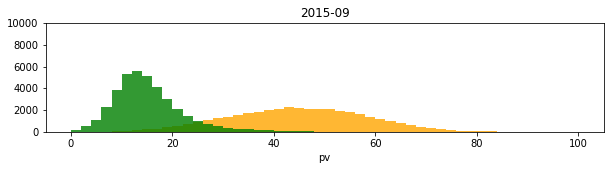

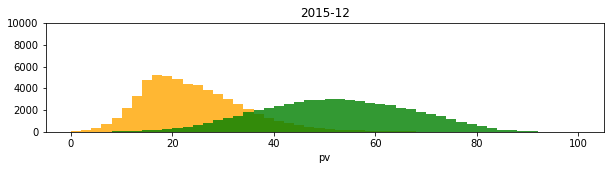

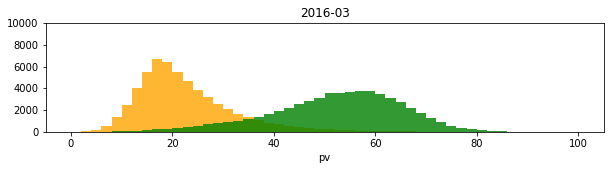

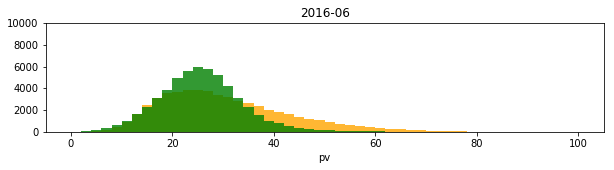

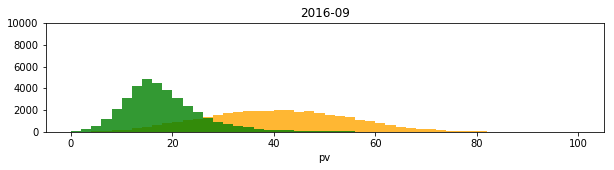

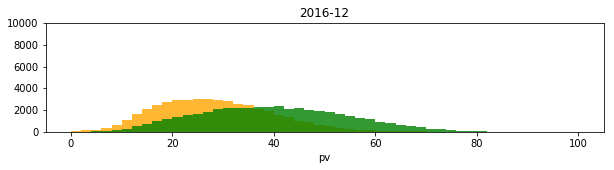

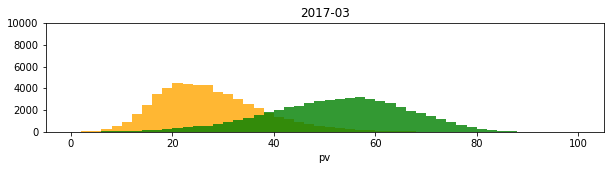

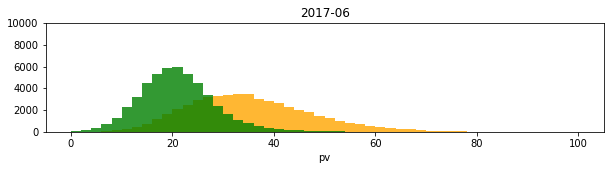

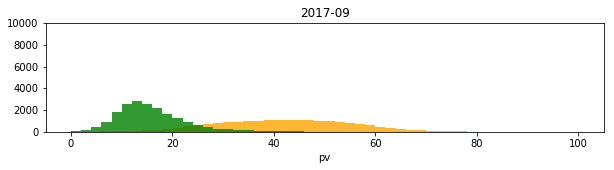

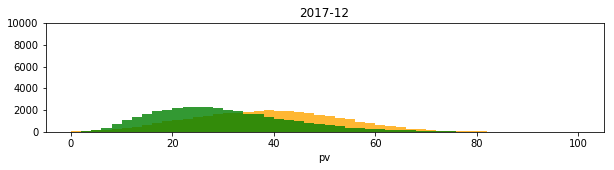

In [182]:
for i in range(0, len(seasonal_landsat.time)):
    
    # Pull out single timestep
    seasonal_layer = seasonal_landsat.isel(time=i)

    # Classify to fractional cover (% growing vegetation, % dry/dead vegetation, % bare soil)
    frac_classes = frac_coverage_classify(seasonal_layer, clean_mask = np.ones(seasonal_layer.red.shape).astype(bool))
    
    # Set nodata pixels to NaN
    frac_classes = frac_classes.where(frac_classes != 0)
    
    # Plot bare soil and growing vegetation pixels as histograms
    fig, ax = plt.subplots(figsize=(10, 2))
    frac_classes.bs.plot.hist(bins=50, range=(0, 100), ylim=(0,10000),  ax=ax, alpha=0.8, color='orange')
    frac_classes.pv.plot.hist(bins=50, range=(0, 100), ylim=(0,10000),  ax=ax, alpha=0.8, color='green')
    plt.title(str(seasonal_landsat.time.isel(time=i).values)[:7])
    